In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


In [3]:
class Net(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1) # 3 input layers (RGB), output layers, kernel size, for 28x28 this conv is type 'same'
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # kernel size, stride
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1) # 3 input layers (RGB), output layers, kernel size
        self.flatten2 = nn.Flatten()
        self.fc1 = nn.Linear(20*7*7, num_classes)

    def forward(self, x):
        # Implement the forward function in the network
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0],1,-1,x.shape[3]) # Unnecessary but oh well it works
        x = self.flatten2(x)
        x = self.fc1(x)
       
        return x
    
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    loss_train = []
    for epoch in range(num_epochs):
        for batch_nr, (data,labels) in enumerate(train_loader):
            data = data.to(device=device)
            labels = labels.to(device=device)
            prediction = model(data)
            loss = criterion(prediction,labels)
            loss_train.append(float(torch.Tensor.cpu(loss)))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
     
    plt.rcParams['figure.figsize'] = [5, 5]
    
    plt.plot(range(0,len(loss_train)),loss_train)
    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title('Training Set')
    plt.show()
    
    return model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
BATCH_SIZE = 10
BATCH_SIZE_TEST = 10000

training_data = datasets.MNIST(
    root="MNIST",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

trainloader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE,
                                          shuffle=True)


test_data = datasets.MNIST(
    root="MNIST",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

testloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE_TEST,
                                         shuffle=False)

# Accurate Net

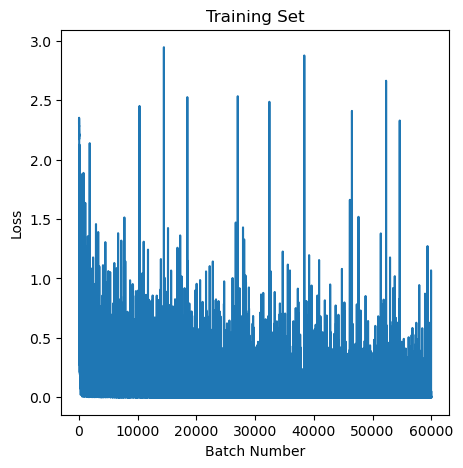

In [25]:
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trained_model = train_model(model, criterion, optimizer, trainloader, 10)

In [26]:
correct = 0
total = 0
y_pred = []
y_true = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch_nr, data in enumerate(testloader):
        images, labels = data
        images = images.to(device=device)
        labels = labels.to(device=device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred = np.concatenate((y_pred,torch.Tensor.cpu(predicted)))
        y_true = np.concatenate((y_true,torch.Tensor.cpu(labels)))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 98 %


In [38]:
# BATCH, RGB, SIZE1, SIZE2 -- what the network takes as input

trained_model.fc1 = nn.Identity() #
trained_model.flatten2 = nn.Identity()
print(trained_model)
with torch.no_grad():
    for batch_nr, (data,labels) in enumerate(testloader):
        #data[:,0,:,:] = training_data.data
        #print(np.shape(data))
        data = data.to(device)
        y = trained_model(data) # Getting the output from entire test set in one tensor
        y2 = torch.Tensor.cpu(y[:,0,:,:]).detach().numpy() # Going over to numpy array and getting rid of 2nd dim
print(torch.Tensor.size(y))
print(y2.shape)
labels = torch.Tensor.cpu(labels).detach().numpy()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten2): Identity()
  (fc1): Identity()
)
torch.Size([10000, 1, 140, 7])
(10000, 140, 7)


## t-SNE

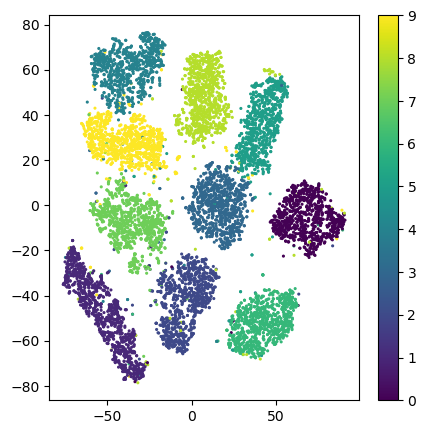

In [50]:
# Reshape to [num of samples, spatial area * depth (feature maps)]
y3 = np.reshape(y2,[-1,980])
y3.shape

from sklearn.manifold import TSNE
X = TSNE().fit_transform(y3)
X.shape

plt.scatter(x = X[:,0], y = X[:,1], c=y_pred, s = 1.5)
plt.colorbar()
plt.show()

## PCA

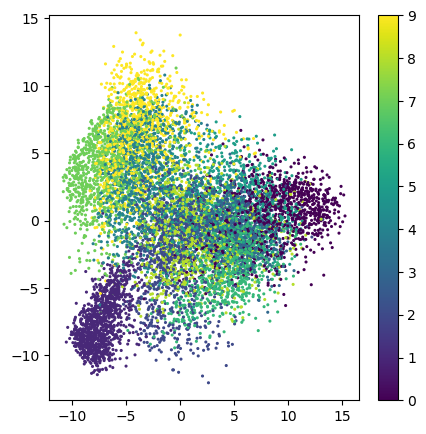

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(y3)
X = pca.transform(y3)
X.shape

plt.scatter(x = X[:,0], y = X[:,1],c = y_pred, s=1.5)
plt.colorbar()
plt.show()

# Unaccurate Net

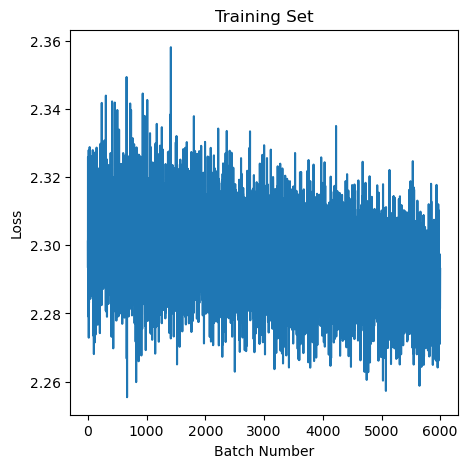

In [52]:
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

trained_model = train_model(model, criterion, optimizer, trainloader, 1)

In [53]:
correct = 0
total = 0
y_pred = []
y_true = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for batch_nr, data in enumerate(testloader):
        images, labels = data
        images = images.to(device=device)
        labels = labels.to(device=device)
        outputs = trained_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred = np.concatenate((y_pred,torch.Tensor.cpu(predicted)))
        y_true = np.concatenate((y_true,torch.Tensor.cpu(labels)))
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 23 %


In [54]:
# BATCH, RGB, SIZE1, SIZE2 -- what the network takes as input

trained_model.fc1 = nn.Identity() #
trained_model.flatten2 = nn.Identity()
print(trained_model)
with torch.no_grad():
    for batch_nr, (data,_) in enumerate(testloader):
        #data[:,0,:,:] = training_data.data
        #print(np.shape(data))
        data = data.to(device)
        y = trained_model(data) # Getting the output from entire test set in one tensor
        y2 = torch.Tensor.cpu(y[:,0,:,:]).detach().numpy() # Going over to numpy array and getting rid of 2nd dim
print(torch.Tensor.size(y))
print(y2.shape)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten2): Identity()
  (fc1): Identity()
)
torch.Size([10000, 1, 140, 7])
(10000, 140, 7)


## t-SNE

(10000, 980)


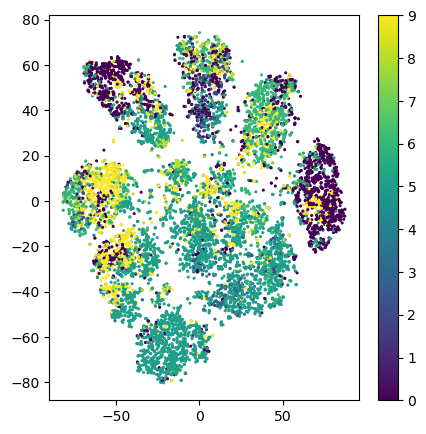

In [55]:
# Reshape to [num of samples, spatial area * depth (feature maps)]
y3 = np.reshape(y2,[-1,980])
print(y3.shape)

from sklearn.manifold import TSNE
X = TSNE().fit_transform(y3)
X.shape

plt.scatter(x = X[:,0], y = X[:,1],c = y_pred, s=1.5)
plt.colorbar()
plt.show()

## PCA

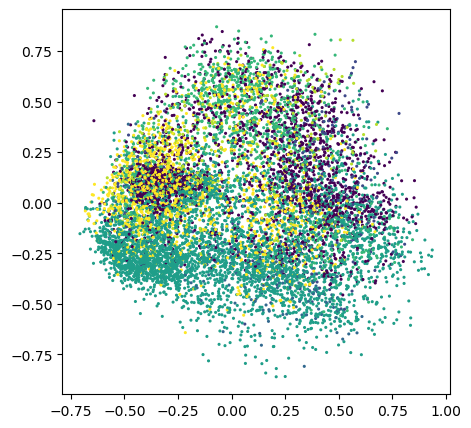

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(y3)
X = pca.transform(y3)
X.shape

plt.scatter(x = X[:,0], y = X[:,1],c = y_pred, s=1.5)
plt.colorbar()
plt.show()